## Парсинг данных

In [ ]:
import requests
from multiprocessing.dummy import Pool as ThreadPool
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [3]:
def moneyfrom(in_str):
    get_data = [int(s) for s in 
                in_str.replace("-", " ").replace("–", " ").split(" ") if s.isdigit()]
    if len(get_data) == 2:
        if get_data[0] == 700:
            return 2
        if get_data[0] == 1500:
            return 3
    else:
        if get_data[0] == 700:
            return 1
        if get_data[0] == 2500:
            return 4

def getInfoFromResponse(data, resp, num_resp):
    if resp.status_code != 200:
        print("Error", num_resp)
        return
    if num_resp % 20 == 0:   
        print(resp, num_resp)
    bs = BeautifulSoup(resp.text, 'lxml')
    for item in bs.find_all('div', 'places_info'): 
        find_name = item.find('span', 'places_name')
        if find_name is not None: 
            name = find_name.text.strip()
        else: 
            name = None

        find_address = item.find('span', 'places_address')
        if find_address is not None:     
            address = find_address.text.strip()
        else: 
            address = None

        find_metro = item.find('span', 'places_metro')
        if find_metro is not None:     
            metro = find_metro.text.strip()[3:]
        else: 
            metro = None

        find_rating = item.find('div', 'rating_number')
        if find_rating is not None: 
            rating = item.find('div', 'rating_number').text.strip()
        else:
            rating = None
        
        find_money = item.find('span', "range s-tooltip")
        if find_money is not None:
            money = moneyfrom(find_money.get("data-title"))
        else:
            money = None

        data.append((name, address, metro, rating, money))

In [4]:
data = list()
FIRST_URL = "https://www.afisha.ru/msk/restaurants/restaurant_list/"
first_resp = requests.get(FIRST_URL)
getInfoFromResponse(data, first_resp, 1)

t = ThreadPool(2)
start_page = 2
end_page = 453
r = t.map(lambda x: getInfoFromResponse(data, 
                    requests.get("https://www.afisha.ru/msk/restaurants/restaurant_list/page%d/?view=list" % x), x), 
          range(start_page, end_page))
t.close()
t.join()

<Response [200]> 60
<Response [200]> 20
<Response [200]> 80
<Response [200]> 40
<Response [200]> 100
<Response [200]> 120
<Response [200]> 180
<Response [200]> 140
<Response [200]> 200
<Response [200]> 160
<Response [200]> 220
<Response [200]> 240
<Response [200]> 300
<Response [200]> 260
<Response [200]> 320
<Response [200]> 280
<Response [200]> 340
<Response [200]> 360
<Response [200]> 420
Error 428
Error 429
Error 430
Error 431
Error 432
Error 433
Error 434
Error 435
Error 436
Error 437
Error 438
Error 439
Error 440
Error 441
Error 442
Error 443
Error 444
Error 445
Error 446
Error 447
Error 448
Error 449
Error 450
Error 451
Error 452
<Response [200]> 380
<Response [200]> 400


In [46]:
import pandas as pd

In [5]:
df = pd.DataFrame(np.array(data, dtype = object), columns=["Name", "Address", "Metro", "Rating", "Money"])

In [6]:
df.to_csv("parsed_afisha.csv", sep=',', encoding='utf-8')

In [59]:
df = pd.DataFrame.from_csv("parsed_afisha.csv", sep=',', encoding='utf-8')

In [60]:
df.head()

,Name,Address,Metro,Rating,Money
0,Хлеб и вино,"просп. Вернадского, 94, корп. 8, ЖК «Миракс-парк»","Юго-Западная, Тропарево",NaN,2.0
1,Beer Happens,"Сретенка, 24/2, стр. 1",Сухаревская,9.1,2.0
2,Винный базар на Комсомольском,"Комсомольский просп., 14/1, корп. 2",Парк культуры,9.1,2.0
3,Grammy's,"Кутузовский просп., 2/1, стр. 6, в Конгресс-па...",Киевская,9.0,3.0
4,Mitzva Bar,"Пятницкая, 3/4, стр. 1","Новокузнецкая, Третьяковская",9.0,2.0


In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

mo_gdf = gpd.read_file('./atd/mo.shp')
mo_gdf.head()

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"(POLYGON ((36.8031012 55.4408329, 36.8031903 5..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.4276499 55.7482092, 37.4284863 55..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.8035692 55.4516224, 36.8045117 55..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.9372397 55.2413907, 36.9372604 55..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.4395575 55.6273129, 37.4401803 55..."


In [65]:
import geocoder

g = geocoder.yandex('Комсомольский просп., 14/1, корп. 2')
g.json

{'accuracy': 'exact',
 'address': 'Russian Federation, Moscow, Komsomolsky Avenue, 14/1к2',
 'country': 'Russian Federation',
 'country_code': 'RU',
 'description': 'Moscow, Russian Federation',
 'lat': '55.731374',
 'lng': '37.589985',
 'ok': True,
 'quality': 'house',
 'raw': {'Point': {'pos': '37.589985 55.731374'},
  'boundedBy': {'Envelope': {'lowerCorner': '37.58588 55.729057',
    'upperCorner': '37.59409 55.73369'}},
  'description': 'Moscow, Russian Federation',
  'metaDataProperty': {'GeocoderMetaData': {'Address': {'Components': [{'kind': 'country',
       'name': 'Russian Federation'},
      {'kind': 'province', 'name': 'Tsentralny federalny okrug'},
      {'kind': 'province', 'name': 'Moscow'},
      {'kind': 'locality', 'name': 'Moscow'},
      {'kind': 'street', 'name': 'Komsomolsky Avenue'},
      {'kind': 'house', 'name': '14/1к2'}],
     'country_code': 'RU',
     'formatted': 'Moscow, Komsomolsky Avenue, 14/1к2',
     'postal_code': '119034'},
    'AddressDetails': {

In [67]:
g.json['lat'], g.json['lng']

('55.731374', '37.589985')

In [ ]:
lat = list()
lng = list()

for address in df.Address:
    if type(address) == str:
        g = geocoder.yandex(address)
        if g.json is not None:
            lat.append(g.json['lat'])
            lng.append(g.json['lng'])
        else:
            lat.append(None)
            lng.append(None)
    else:
        lat.append(None)
        lng.append(None)

In [ ]:
df['lng'] = lng
df['lat'] = lat
df['District'] = None

In [ ]:
from shapely.geometry import *

gSerDistricts = GeoSeries(mo_gdf.geometry)

for i in range(df.shape[0]):
    if df.iloc[i].lng is not None and df.iloc[i].lat is not None:
        p = Point(float(df.iloc[i].lng), float(df.iloc[i].lat))
        intercept_list = list(gSerDistricts.intersects(p))
        if np.sum(intercept_list) > 0:
            ndf.iloc[i, 7] = mo_gdf[intercept_list].iloc[0].NAME

In [ ]:
df.to_csv("parsed_afisha_districts.csv", sep=',', encoding='utf-8')

In [70]:
df = pd.DataFrame.from_csv("./parsed_afisha_districts.csv", sep=',', encoding='utf-8')

In [72]:
df.head(10)

,Name,Address,Metro,Rating,Money,lat,lng,District
0,Хлеб и вино,"просп. Вернадского, 94, корп. 8, ЖК «Миракс-парк»","Юго-Западная, Тропарево",NaN,2.0,55.652674,37.476402,Тропарёво-Никулино
1,Beer Happens,"Сретенка, 24/2, стр. 1",Сухаревская,9.1,2.0,55.769838,37.632889,Красносельский
2,Винный базар на Комсомольском,"Комсомольский просп., 14/1, корп. 2",Парк культуры,9.1,2.0,55.731374,37.589985,Хамовники
3,Grammy's,"Кутузовский просп., 2/1, стр. 6, в Конгресс-па...",Киевская,9.0,3.0,NaN,NaN,NaN
4,Mitzva Bar,"Пятницкая, 3/4, стр. 1","Новокузнецкая, Третьяковская",9.0,2.0,55.745427,37.627166,Замоскворечье
5,Боэми,"Рочдельская, 11/5","Краснопресненская, Баррикадная",9.0,3.0,55.756462,37.569953,Пресненский
6,Lumberjack Bar,"Б.Спасоглинищевский пер., 3, стр. 5",Китай-город,9.0,3.0,55.756437,37.635188,Басманный
7,Бутчер,"Лубянский пр., 15/2",Китай-город,9.0,4.0,55.756817,37.632305,Басманный
8,Лейка,"Головинское ш., 5, ТЦ «Водный», 3 этаж",Водный стадион,9.0,2.0,55.840240,37.492024,Головинский
9,Pinzeria by Bontempi,"Б.Знаменский пер., 2, стр. 3",Кропоткинская,8.9,2.0,55.745934,37.602517,Хамовники


## Отрисовка 

Загрузим в df данные баров. В mo_gdf -- администранивное деление Москвы

In [128]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_csv("./parsed_afisha_districts.csv", sep=',', encoding='utf-8')
mo_gdf = gpd.read_file('./atd/mo.shp')

Сгруппируем df по районам

In [129]:
df_grouped = df.groupby("District").mean()
df_grouped["Count"] = df.groupby("District").count()["lat"]
df_grouped.head()

,Rating,Money,lat,lng,Count
District,,,,,
Академический,6.146154,1.784615,55.684704,37.571702,68
Алексеевский,7.450000,1.536585,55.812199,37.643791,44
Алтуфьевский,NaN,1.428571,55.881580,37.592680,7
Арбат,6.538095,1.820961,55.751418,37.592596,244
Аэропорт,5.100000,1.557377,55.802947,37.530747,62


Соединим полученные датасеты

In [130]:
mo_gdf_joined = mo_gdf.set_index('NAME').join(df_grouped)
mo_gdf_joined.head(4)

,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry,Rating,Money,lat,lng,Count
NAME,,,,,,,,,,,,
Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"(POLYGON ((36.8031012 55.4408329, 36.8031903 5...",NaN,NaN,NaN,NaN,NaN
Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.4276499 55.7482092, 37.4284863 55...",5.5,1.510204,55.744668,37.50203,50.0
Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.8035692 55.4516224, 36.8045117 55...",NaN,NaN,NaN,NaN,NaN
Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.9372397 55.2413907, 36.9372604 55...",NaN,NaN,NaN,NaN,NaN


Тепловая карта по средней дороговизне

/Users/anton/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


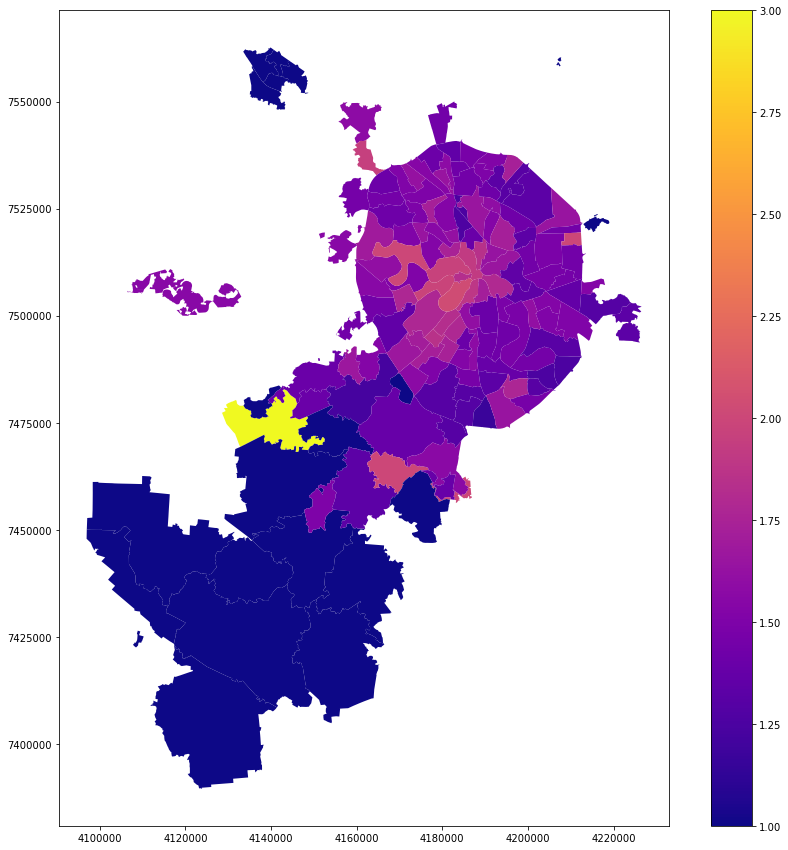

In [131]:
mo_gdf_wm = mo_gdf_joined.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = "Money", linewidth=0.5, cmap='plasma', legend = True, figsize=[15,15])

Тепловая карта по среднему рейтингу

/Users/anton/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


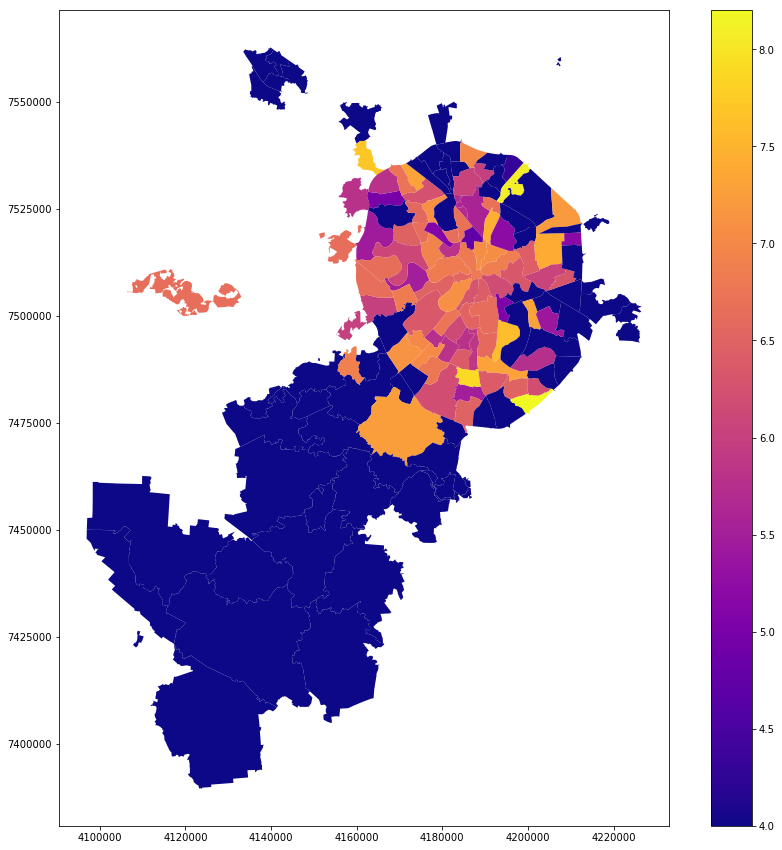

In [132]:
mo_gdf_wm = mo_gdf_joined.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = "Rating", linewidth=0.5, cmap='plasma', legend = True, figsize=[15,15])

Тепловая карта количества баров

/Users/anton/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


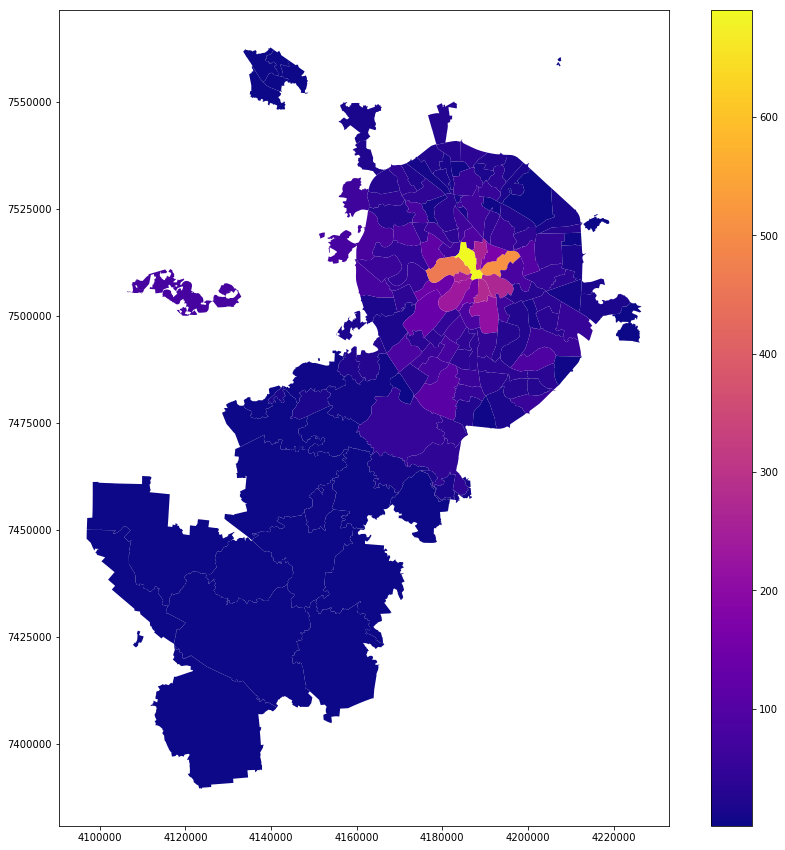

In [126]:
mo_gdf_wm = mo_gdf_joined.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = "Count", linewidth=0.5, cmap='plasma', legend = True, figsize=[15,15])